# Extraire des opinions en s'appuyant sur les arbres syntaxiques

Dans l'extraction précédente, on s'appuyer sur les cooccurrences entre certains termes (définit dans des lexiques). Si les relations extraites donne un apercu intéressant et qui a motivé la mise en place d'une campagne d'annotation, il existe d'autres méthodes en TAL permettant d'établir des régles d'extraction de relation. Ici, on s'intéressera au relation grammaticale apparaissant dans les arbres de dépendances.

## Arbre de dépendances

Un **arbre de dépendances** représentent les relations entre les mots d'une phrase. Ces relations sont caractérisés dans la "grammaire de la dépendance". Par exemple, pour la phrase "il ne faut surtout pas augmenter le nombre de pistes cyclables.", on obtient l'arbre suivant : 
![exemple](resources/imgs/dep_parsing_ex.png)

Parmi les dépendances présentes dans la phrase, la relation *nmod* indique que la source "nombre" est un modificateur nominal de la cible "pistes cyclables". Ou encore la relation *det* indique que "le" est le déterminant de "nombre". Ici, l'ensemble de relations utilisées proviennent de l'*Universal Dependencies* [ref](https://universaldependencies.org/#language-fr).


## Importation des modules

In [19]:
import uuid

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

# Custom library
from lib.textometry import *
from lib.helpers import *
from lib.constant import *
from lib.cooc import *
from lib.utils import match_sequences


from lib.utils import partofspeech
from stop_words import get_stop_words
fr_stop = get_stop_words("french")
import spacy
from spacy import displacy
from spacy.pipeline import EntityRuler


# Pandas shoots warning non-stop ... so chouh !
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# NEW

#NEW  END

code_questions = {
    1:"transition_eco",
    2:"democratie_et_citoy",
    3:"fiscalite_et_depense_publique",
    4:"organisation_de_etat_et_service_pub"
}

## Chargement des données

In [20]:
 # DONNEE GRAND DEBAT
df_data = pd.read_csv("data/LA_TRANSITION_ECOLOGIQUE.csv",dtype={"authorZipCode":str})
df_classification = pd.read_csv("data/transition_eco.csv",sep="\t",dtype={"authorZipCode":str})

In [21]:
# MODELE SPACY
nlp = spacy.load("fr") 

In [22]:
# CHARGEMENT DE L'ONTOLOGIE du TRANSPORT
df_onto = pd.read_csv("./resources/lexiques/ontology.csv",sep="\t",index_col=0)
df_onto.fillna("na_na_batman",inplace=True)
df_onto["altLabel"] = df_onto.altLabel.apply(lambda x :x.split("|"))
df_onto["id_"] = np.arange(len(df_onto))
df_onto

,prefLabel,altLabel,id_
0,action,[na_na_batman],0
1,aller en ville,[faire du shopping],1
2,arrêt,[stop],2
3,arrêt de bus,[na_na_batman],3
4,arrêt de tramway,[arrêt de tram],4
...,...,...,...
109,solex,[na_na_batman],109
110,train corail,[na_na_batman],110
111,trajet personnel,[déplacement personnel],111
112,voiture thermique,[voiture essence],112


In [23]:
lexique_verbe = pd.read_csv("./resources/lexiques/dico_verbe_changement.txt")
verbe_class = dict(lexique_verbe.values)
lexique_verbe.head(5)

,word,class
0,accélérer,P
1,ralentir,N
2,limiter,N
3,construire,P
4,détruire,N


## Mise en place de l'algorithme d'extraction

Pour éviter de compliquer la tâche dès le début, l'algorithme se focalisera sur l'extraction d'opinion dont la cible appartient à un lexique que nous avons mis en place. Ici, le lexique correspond à celui du transport. On y retrouve des termes associés aux moyens de locomotions, des entreprises, des infrastructures de transport, etc.

Ici, nous définissons un opinion comme composée de trois éléments:
 
 * **Objet** : la cible de l'opinion
 * **Feature** : régulièrement une opinion ne cible pas l'objet dans sa globalité mais une caractéristique bien précise, que l'on nomme ici "features"
 * **Polarisateur** : donne la polarité exprimé concernant l'objet ciblé ou une de ses features.

## Détection des termes présents dans les lexiques

A la base des opinions que nous souhaitons extraire, ici nous avons décidé de limité les objets en s'appuyant sur un lexique. Pour détecter les objets du lexique présents dans une réponse, nous utilisons la class `EntityRuler` qui nous permet de faire cela.

In [24]:
ruler = EntityRuler(nlp)

patterns = []
for ix,row in df_onto.iterrows():
    patterns.append({"label":"TRAN","pattern":[{"LEMMA":f} for f in row.prefLabel.split()],"id":str(row.id_)})
    for label in row.altLabel:
        if label == "na_na_batman":
            continue
        patterns.append({"label":"TRAN","pattern":[{"LEMMA":f} for f in label.split()],"id":str(row.id_)})
ruler.add_patterns(patterns)
nlp.add_pipe(ruler)


In [34]:
doc = nlp("il ne faut surtout pas augmenter le nombre de pistes cyclables.")

## Algorithme d'extraction

Comme il a été dit précédement, nous utiliserons les informations provenant de l'arbre de dépendance extraite d'une réponse pour extraire les opinions. Pour reprendre la phrase donnée précédement, l'arbre de dépendance est le suivant :

In [26]:
displacy.render(doc, style='dep')

Pour extraire les relations, on s'appuie sur un prédicat simple : l'objet est un terme présent dans le lexique, le polarisateur est un verbe et (si elle existe) une feature est un NOM relié à l'objet (souvent avec la relation nmod). Pour tester cela, on utilise le code ci-dessous. Pour résumer, voici le pseudo-code:
```
* OPINIONS = []
* Pour chaque OBJET dans DOCUMENT
    * OPINION,FEAT,POLARISATEUR,I = NULL,NULL,NULL,0
    * MOT = OBJET
    * Tant que OPINION = NULL
        * Si MOT = VERBE
            * POLARISATEUR = VERBE
            * Si FEATURE != NULL 
                OPINION = POLARISATEUR --> FEAT --> OBJET
            * Si FEATURE == NULL
                * OPINION = POLARISATEUR --> OBJET
            * Si POLARISATEUR est relié à ("ne" ou "pas")
                * OPINION = NEG --> OPINION
         * Si MOT.PartOfSpeech == NOM
            * FEAT = MOT
         * MOT = OBJET.ANCETRE # On remonte les dépendances
         * SI i>10: # Quand aucun verbe n'est trouvé dans la chaine de dépendances à l'objet
             BREAK
         * I = I + 1
     * Si OPINION != NULL
         * append(OPINIONS,OPINIONS)
* Retourne OPINIONS
```

In [35]:
def get_relation(doc,span):
    neg,verb, feature, ent = 0,None,None,span.lemma_
    f, i,last_str = False, 0, span.lemma_
    head = span.root.head
    while not f:
        if last_str == head.text:
            f=True
        elif head.pos_ =="VERB":
            f=True
            verb = head.lemma_.lower()
            children = [child.text for child in list(head.children)]
            if "ne" in children or "pas" in children:
                neg= 1
        elif head.pos_ == "NOUN":
            feature = head.text
        last_str = head.text
        head = head.head
        i+=1
        if i >10:#Eviter les boucles infinies
            break
    return neg,verb, feature, ent
        
def get_all_relation(doc):
    data =[]
    for ent in doc.ents:
        if ent.label_ == "TRAN":
            neg,verb,feat,term = get_relation(doc,ent)
            if verb:
                data.append([neg,verb,feat,term])
    return pd.DataFrame(data,columns="is_neg verb feat term".split())
get_all_relation(doc)

,is_neg,verb,feat,term
0,1,augmenter,nombre,piste cyclable


On applique l'algorithme d'extraction sur l'ensemble du corpus.

In [ ]:
final_df= []
for question in tqdm(analysed_questions[code_questions[1]]):
    data_question  = get_question_with_transport_data(df_data,df_classification,question).values
    list_ids = df_data["id"][get_question_with_transport_data(df_data,df_classification,question).index].values
    df_q = get_all_relation(nlp(data_question[0]))
    df_q["id_doc"] = [list_ids[0]] * len(df_q)
    i=1
    for doc in tqdm(nlp.pipe(data_question[1:], batch_size=1000,n_threads=-1),total = len(data_question)-1):
        nee = get_all_relation(doc)
        nee["id_doc"] = [list_ids[i]] * len(nee)
        df_q = pd.concat((df_q,nee))
        i += 1
    df_q["question"] = [question]*len(df_q)
    final_df.append(df_q)

On sauvegarde le résultat dans un fichier CSV.

In [38]:
output_fn = "dep_parsing.csv"
pd.concat(final_df).to_csv(output_fn,index=False,sep="\t")

## Visualisation des résultats

Pour visualisater la répartion des opinions extraites selon le verbe (polarisateur) utilisé, on utilise la représentation [TreeMap](https://plotly.com/python/treemaps/) implémenté dans Plotly (librairie python).

In [39]:
df_final = pd.read_csv(output_fn,sep="\t")
df_final

,is_neg,verb,feat,term,id_doc,question
0,0,baisser,part,transport,UHJvcG9zYWw6MmEwMjMyNDYtMWUyMi0xMWU5LTk0ZDItZm...,QUXVlc3Rpb246MTYx - Que faudrait-il faire selo...
1,0,baisser,part,routier,UHJvcG9zYWw6MmEwMjMyNDYtMWUyMi0xMWU5LTk0ZDItZm...,QUXVlc3Rpb246MTYx - Que faudrait-il faire selo...
2,0,mettre,NaN,poids lourd,UHJvcG9zYWw6MmEwMjMyNDYtMWUyMi0xMWU5LTk0ZDItZm...,QUXVlc3Rpb246MTYx - Que faudrait-il faire selo...
3,0,proposer,NaN,véhicule,UHJvcG9zYWw6YTQwNTQ3YmYtMWUyMi0xMWU5LTk0ZDItZm...,QUXVlc3Rpb246MTYx - Que faudrait-il faire selo...
4,0,proposer,véhicule,rouler,UHJvcG9zYWw6YTQwNTQ3YmYtMWUyMi0xMWU5LTk0ZDItZm...,QUXVlc3Rpb246MTYx - Que faudrait-il faire selo...
...,...,...,...,...,...,...
213810,0,utiliser,véhicules,moto,UHJvcG9zYWw6ZDhhODE5NzYtNDlkMC0xMWU5LWJmNTYtZm...,"QUXVlc3Rpb246MjA3 - Si non, quelles sont les s..."
213811,0,devoir,NaN,voie,UHJvcG9zYWw6ZDhhODE5NzYtNDlkMC0xMWU5LWJmNTYtZm...,"QUXVlc3Rpb246MjA3 - Si non, quelles sont les s..."
213812,0,aménager,NaN,voie,UHJvcG9zYWw6ZDhhODE5NzYtNDlkMC0xMWU5LWJmNTYtZm...,"QUXVlc3Rpb246MjA3 - Si non, quelles sont les s..."
213813,0,inutiliser,NaN,transport,UHJvcG9zYWw6MTE3NDM1NTEtNDlkMS0xMWU5LWJmNTYtZm...,"QUXVlc3Rpb246MjA3 - Si non, quelles sont les s..."


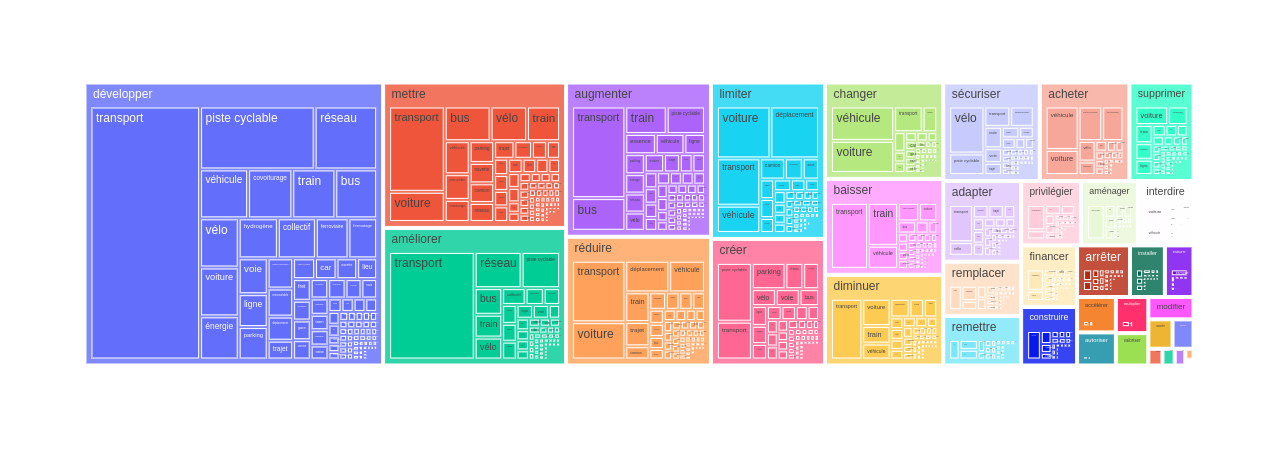

In [44]:
import plotly.express as px
test = df_final[df_final.verb.isin(verbe_class)]
test = test[test.is_neg == 0]
fig = px.treemap(test.groupby("verb term".split(),as_index=False).count(), path=['verb', 'term'],values="is_neg")
fig.show()